<a href="https://colab.research.google.com/github/fajardgb/n-bitflipflop-ameretat/blob/main/Copy_of_Group_2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/ComparingNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/projects/project-notebooks/ComparingNetworks.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>


In [1]:
##steps for notebook
# import repos and install packages
# create 3BFF env
# train GRU and NODE
# fit affine transformation btwn them
# find fixed points btwn them
# train 2 more models  (RNN, LSTM) --> maybe just the LSTM?
# compare their activity using DSA -- 6 comparisons
# create a 4BFF and repeat the DSA analysis
# compare complexities of the 2 tasks (??)

###in the chart, they suggest DSA on the 1st two (GRU vs NODE) and then DSA on 4BFF with GRU vs LSTM

In [2]:
print("Hello")

Hello


In [3]:
! git clone https://github.com/fajardgb/random-target-ameretat.git

fatal: destination path 'random-target-ameretat' already exists and is not an empty directory.


In [4]:
! git clone https://github.com/fajardgb/n-bitflipflop-ameretat

fatal: destination path 'n-bitflipflop-ameretat' already exists and is not an empty directory.


In [5]:
#get ctd repo

! git clone https://github.com/neuromatch/ComputationThruDynamicsBenchmark #ctd/task_modeling/model/rnn.py - path for model architecture creation
%cd ComputationThruDynamicsBenchmark
! pip install -e .

# RUN THIS CELL, THEN RESTART SESSION AS PROMPTED (BUTTON AT BOTTOM OF THIS CELL'S FINISHED OUTPUT). DO NOT NEED TO RUN AGAIN


fatal: destination path 'ComputationThruDynamicsBenchmark' already exists and is not an empty directory.
/content/ComputationThruDynamicsBenchmark
Obtaining file:///content/ComputationThruDynamicsBenchmark
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ctd
    Found existing installation: ctd 1.0
    Uninstalling ctd-1.0:
ERROR: Operation cancelled by user


KeyboardInterrupt: 

In [ ]:
## GET BACK TO THE DIRECTORY AND CONFIGURE .env

%cd /content/ComputationThruDynamicsBenchmark/
envStr = """HOME_DIR=/content/ComputationThruDynamicsBenchmark/
TRAIN_INPUT_FILE=train_input.h5\nEVAL_INPUT_FILE=eval_input.h5
EVAL_TARGET_FILE=eval_target.h5
"""

with open('.env','w') as f:
  f.write(envStr)



In [ ]:
#get DSA repo

!git clone https://github.com/mitchellostrow/DSA
%cd DSA/
!pip install -e .

In [6]:
# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
import logging

# comment the next three lines if you want to see all training logs
pl_loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict if 'pytorch_lightning' in name]
for pl_log in pl_loggers:
    logging.getLogger(pl_log.name).setLevel(logging.WARNING)

random.seed(42)

dotenv.load_dotenv(override=True)
#HOME_DIR = os.getenv('HOME_DIR')
HOME_DIR = '/content'
if HOME_DIR is None:
    HOME_DIR = ""
print(HOME_DIR)

/content


# **Import the trained models**

In [7]:
import pickle
import os

os.environ['HOME_DIR'] = '/content'

In [8]:
def get_path(task, model_name):
    '''
    task: 3-bit or 4-bit flipflop
    model_name: GRU_128, NODE_3, Vanilla_RNN_128, DriscollRNN_128
    '''

    path = pathlib.Path(HOME_DIR) / 'n-bitflipflop-ameretat' / 'models' / '{}'.format(task) / 'models_{}'.format(model_name) / ""

    model = pickle.load(open(path / 'model.pkl', 'rb'))
    data_module = pickle.load(open(path / 'datamodule_sim.pkl', 'rb'))

    return model, data_module, path



In [9]:
# import models trained on 3bff

gru_3, gru_data_module_3, gru_path = get_path('3-bit', 'GRU_128')
node_3, node_data_module_3, node_path = get_path('3-bit', 'NODE_3')
vanilla_rnn_3, vanilla_rnn_data_module_3, vanilla_path = get_path('3-bit', 'Vanilla_RNN_128')
driscoll_rnn_3, driscoll_rnn_data_module_3, driscoll_path = get_path('3-bit', 'DriscollRNN_128')

# **Inspect latent activity between the 2 models**

In [10]:
from ctd.comparison.analysis.tt.tt import Analysis_TT
import ctd.task_modeling.datamodule.task_datamodule as task_dm
#this is a temporary patch to fix a path issue

task_dm.HOME_DIR = '/content'

filepath_with_slash = str(gru_path) + '/'

# Create your analysis object
analysis_GRU_128 = Analysis_TT(
    run_name = "GRU_128_3bff",
    filepath = filepath_with_slash)

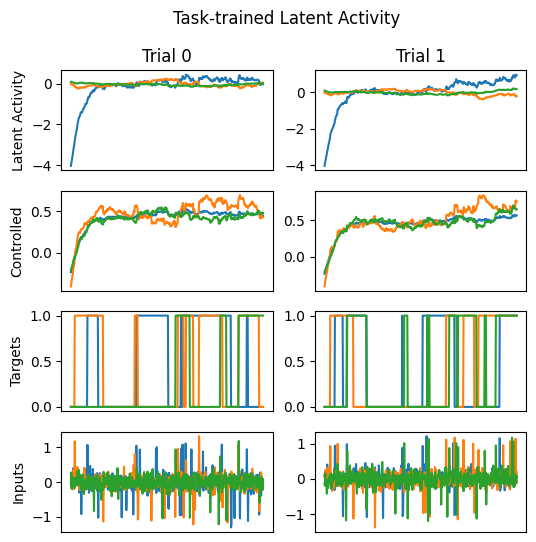

In [11]:
# same as above but for NODE

nodepath_with_slash = str(node_path) + '/'

analysis_NODE = Analysis_TT(
    run_name = "NODE_3_3bff",
    filepath = nodepath_with_slash)

analysis_NODE.plot_trial_io(num_trials = 2)

In [12]:
print(f"All data shape: {analysis_GRU_128.get_latents().shape}")
print(f"Train data shape: {analysis_GRU_128.get_latents(phase = 'train').shape}")
print(f"Validation data shape: {analysis_GRU_128.get_latents(phase = 'val').shape}")

All data shape: torch.Size([1000, 500, 128])
Train data shape: torch.Size([800, 500, 128])
Validation data shape: torch.Size([200, 500, 128])



- `get_latents()`: Returns latent activity of the trained model
- `get_inputs()`: Returns the inputs to the model (for 3BFF, the input pulses)
- `get_model_output()`: Returns a dict that contains all model outputs:
  - controlled - the variable that the model is controlling
  - latents - the latent activity


# **Use affine transformations to compare latent activity**

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA


def extract_latents(model_analysis):
    '''
    Extract the latent activity from 2 separate models
    '''

    source = model_analysis


    # Get the latent activity from the validation phase for each model:

    latents_source = source.get_latents(phase='train').detach().numpy()

    latents_source_val = source.get_latents(phase='val').detach().numpy()

    n_trials, n_timesteps, n_latent_source = latents_source.shape

    n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape

    print(f"Latent shape for source model: {latents_source.shape}")

    return latents_source, latents_source_val

In [14]:

 latents_gru, latents_gru_val = extract_latents(analysis_GRU_128)
 latents_node, latents_node_val = extract_latents(analysis_NODE)



Latent shape for source model: (800, 500, 128)
Latent shape for source model: (800, 500, 3)


# **PCA**

In [17]:
# Perform PCA on both latent spaces to find axes of highest variance

def PCA():
    pca_source = PCA()
    pca_targ = PCA()
    lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
    lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))

    lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
    lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))




In [18]:
# Fit a linear regression model to predict the target latents from the source latents

reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

NameError: name 'lats_source_pca' is not defined

***Explain what is happening;  interpret the above results***



So, the variance weighted R2 from the source to the target is ~0.93.

*Try reversing the direction (the source as NODE and target as GRU) and see how well the model fits*


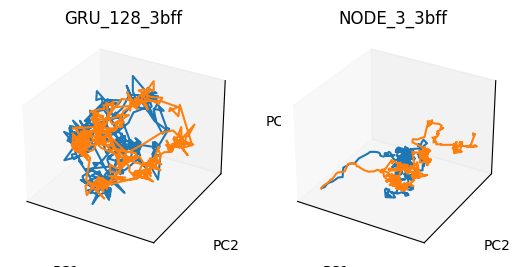

In [19]:
from ctd.comparison.comparison import Comparison

# compare latent activity via affine transformation
# this should produce a plot

comp = Comparison()
comp.load_analysis(analysis_GRU_128, reference_analysis=True)
comp.load_analysis(analysis_NODE)
comp.plot_trials_3d_reference(num_trials=2)

# **Find fixed points between the GRU and NODE**

Use fixed-point finding to inspect the linearized dynamics of the trained model.

Fixed points are points in the dynamics for which the flow field is zero, meaning that points at that location do not move.

In [20]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps = analysis_GRU_128.plot_fps(
        inputs= torch.zeros(3),
        n_inits=1024,
        learning_rate=1e-3,
        noise_scale=0.0,
        max_iters=20000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-5,
    )

KeyboardInterrupt: 

***Explain what we are seeing above; how to interpret
What is the Q value?  What does it tell us?
Whta do the fixed points tell you about the computation for 3BFF?

In [ ]:
with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps = analysis_NODE.plot_fps(
        inputs= torch.zeros(3),
        n_inits=1024,
        learning_rate=1e-3,
        noise_scale=0.0,
        max_iters=20000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-5,
    )

# **Train an LSTM network**

In [ ]:
# Train another model(s) -- start w LSTM, then maybe basic RNN or something else


#lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=1)
# may not be able to just import this from nn.module since it needs to approximate the GRU_Cell
# look in rnn.py to read the requirements


In [ ]:
# and visualize the latent dynamics

# **DSA: GRU vs NODE**

In [ ]:
print(latents_gru_val.shape)
print(latents_node_val.shape)

In [ ]:
## Do DSA on the GRU vs NODE
from DSA import DSA

traj_gru = latents_gru_val.reshape(-1, latents_gru_val.shape[-1])  # shape: (n_trials*n_timesteps, n_latents)
traj_node = latents_node_val.reshape(-1, latents_node_val.shape[-1])

# # Run DSA
n_delays = 20
delay_interval = 10

dsa = DSA(X=traj_gru, Y=traj_node, n_delays=n_delays, delay_interval=delay_interval)
similarity = dsa.fit_score()
print(f"DSA similarity between GRU and NODE: {similarities:.4f}")

In [ ]:
chunk_size = 25  # Creates 20 chunks per trial (500/25)

# Reshape into chunks
n_trials, n_timesteps = 200, 500
n_chunks = n_timesteps // chunk_size

gru_chunks = latents_source_val[:, :n_chunks*chunk_size, :].reshape(
    n_trials * n_chunks, chunk_size * 128  # (4000, 3200)
)

node_chunks = latents_targ_val[:, :n_chunks*chunk_size, :].reshape(
    n_trials * n_chunks, chunk_size * 3    # (4000, 75)
)


In [ ]:
# Reduce GRU chunks to match NODE structure
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
gru_scaled = scaler.fit_transform(gru_chunks)

pca = PCA(n_components=75)  # Match NODE chunk dimension
gru_reduced = pca.fit_transform(gru_scaled)

# Run DSA
dsa = DSA(X=gru_reduced, Y=node_chunks, n_delays=5, delay_interval=2)
similarity = dsa.fit_score()
print(f"DSA similarity: {similarity:.4f}")

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Reduce GRU from 128 to 3 features FIRST
gru_flat = latents_source_val.reshape(-1, 128)  # (100000, 128)

scaler = StandardScaler()
gru_scaled = scaler.fit_transform(gru_flat)

pca = PCA(n_components=3)  # Match NODE's 3 features
gru_reduced_flat = pca.fit_transform(gru_scaled)

# Step 2: Reshape back to original structure
gru_reduced = gru_reduced_flat.reshape(200, 500, 3)  # Now (200, 500, 3)

print(f"GRU explained variance: {pca.explained_variance_ratio_.sum():.3f}")

# Step 3: Now chunk with EQUAL dimensions
chunk_size = 25
n_chunks = 500 // chunk_size

gru_chunks = gru_reduced[:, :n_chunks*chunk_size, :].reshape(
    200 * n_chunks, chunk_size * 3  # (4000, 75)
)

node_chunks = latents_targ_val[:, :n_chunks*chunk_size, :].reshape(
    200 * n_chunks, chunk_size * 3  # (4000, 75)
)

print(f"Perfect match! GRU: {gru_chunks.shape}, NODE: {node_chunks.shape}")



In [ ]:
# Step 4: Run DSA
dsa = DSA(X=gru_chunks, Y=node_chunks, n_delays=5, delay_interval=2)
similarity = dsa.fit_score()
print(f"DSA similarity: {similarity:.4f}")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
labels = ['GRU', 'NODE']
plt.bar(similarity, xticklabels=labels, yticklabels=labels)
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('DSA Score');
plt.title("Dynamic Similarity Analysis Score among Trajectories");

# **DSA: GRU vs VanillaRNN**

In [15]:
# Do DSA on the GRU vs RNN since dims are simliar (same 128 features)

van_path_with_slash = str(vanilla_path) + '/'

analysis_Vanilla_RNN_128 = Analysis_TT(
    run_name = "VAN_3_3bff",
    filepath = van_path_with_slash)



driscoll_path_with_slash = str(driscoll_path) + '/'

analysis_DriscollRNN_128 = Analysis_TT(
    run_name = "DRIS_3_3bff",
    filepath = driscoll_path_with_slash)




In [16]:
 #latent activity throught training, latent activity during validation

 latents_vanilla, latents_vanilla_val = extract_latents(analysis_Vanilla_RNN_128)
 latents_driscoll, latents_driscoll_val = extract_latents(analysis_DriscollRNN_128)

Latent shape for source model: (800, 500, 128)
Latent shape for source model: (800, 500, 128)


In [ ]:
from DSA import DSA

dsa = DSA(X=latents_vanilla, Y=latents_gru, n_delays=5, delay_interval=2)
similarity = dsa.fit_score()
print(f"DSA similarity: {similarity:.4f}")

In [23]:
from DSA import DSA


n_delays = 1
delay_interval = 1

models = [latents_gru, latents_vanilla, latents_driscoll]
dsa = DSA(models, n_delays=n_delays, delay_interval=delay_interval)
similarities = dsa.fit_score()

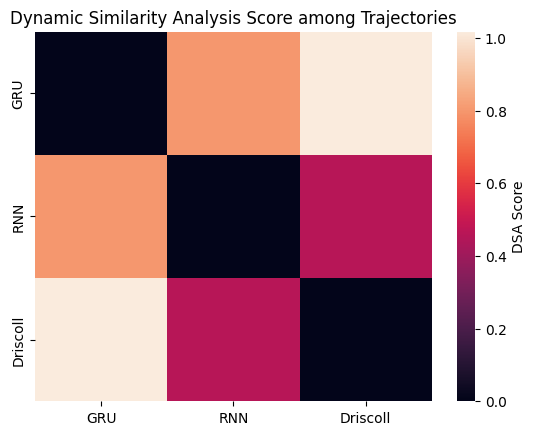

In [24]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

labels = ['GRU', 'RNN', 'Driscoll']
data = np.random.rand(len(labels), len(labels))
ax = sns.heatmap(similarities, xticklabels=labels, yticklabels=labels)
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('DSA Score');
plt.title("Dynamic Similarity Analysis Score among Trajectories");

In [ ]:
# explain how they are simliar, interpret the results

In [ ]:
# try to plot the trajectory

In [26]:
import sys
sys.path.append('content/n-bit-flipflop-ameretat')
from feature_path import *


rep_path(latents_gru_val)

ModuleNotFoundError: No module named 'feature_path'

# **4BFF task**

In [ ]:
# add code to visualize the hypercube

In [ ]:
# train GRU, NODE, and LSTM on 4BFF and save models
# here we should once again import the saved models

In [ ]:
# rerun: affine? fixed point? DSA?

talk about the simliarities/differences between 3 bit and 4


In [ ]:
# compare the complexities of the task?  Not sure how to do that exactly

# **Conclusion**

discussion
